In [1]:
import time

import jax
import jax.numpy as jnp
import diffrax

from rodas5 import Rodas5

In [2]:
mu = 100.0



def f(t, y, args):
    return jnp.array([
        y[1], 
        mu * args[0]**2 * (t + 1) * (1 - y[0]**2)*y[1] - y[0]])



In [3]:
t0, t1 = 0.0, 30*mu
y0 = jnp.array([2., 0.])

maxsteps = 5000

N = 10000

stepsize = t1/N
saveat = diffrax.SaveAt(ts=list(jnp.arange(t0, t1, stepsize)))

integrator = Rodas5()


In [4]:


rtol = 1e-6
atol = 1e-6

n_total = 512

n_batch = 128

arg_total = jnp.arange(1, n_total + 1).reshape((n_total, 1))
# y0_total = jnp.array([[k/n_total, 0.0] for k in range(n_total)]).astype(float)
y0_total = jnp.array([[2.0 + 0.5*(0.5 - k/n_total), 0.0] for k in range(n_total)]).astype(float)

stepsize_controller = diffrax.PIDController(rtol=rtol, atol=atol)
term = diffrax.ODETerm(f)


def solve(y, args):
    return diffrax.diffeqsolve(term, 
                    integrator, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)



solve_vmap = jax.vmap(solve, (0, 0))
start = time.time()
solutions_vmap = solve_vmap(y0_total, arg_total)
end = time.time()

print("time: ", end-start)


/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  2.544614791870117


In [5]:

    
%timeit solve_vmap(y0_total, arg_total)


1.48 s ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
from rodas5batched import Rodas5Batched

integrator_batched = Rodas5Batched()

f_batched = jax.vmap(f, (None, 0 , 0))
term_batched = diffrax.ODETerm(f_batched)

y0_batched = jnp.array([y0_total[k:k+n_batch] for k in range(0,n_total,n_batch)])
arg_batched = jnp.array([arg_total[k:k+n_batch] for k in range(0,n_total,n_batch)])

def solve_batch(y, args):
    return diffrax.diffeqsolve(term_batched, 
                    integrator_batched, 
                    t0=t0, 
                    t1=t1, 
                    dt0=stepsize, 
                    y0=y, 
                    saveat=saveat, 
                    stepsize_controller=stepsize_controller, 
                    max_steps=maxsteps,
                    args=args)

solve_batch_vmap = jax.vmap(solve_batch, (0,0))

start = time.time()
solutions_batch = solve_batch_vmap(y0_batched, arg_batched)
end = time.time()

print("time: ", end-start)


/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/home/tobias/Projects/integrators/.venv/lib/python3.12/site-packages/jax/_src/core.py:678: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


time:  1.2677524089813232


In [7]:
    
%timeit solve_batch_vmap(y0_batched, arg_batched)

323 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
solutions_batch.ys.shape, solutions_batch.ts.shape, solutions_vmap.ys.shape

((4, 10000, 128, 2), (4, 10000), (512, 10000, 2))

In [9]:
batch_ys =  []
for k in range(n_total // n_batch):
    for j in range(n_batch):
        intermediate = solutions_batch.ys[k, :, j, :].squeeze()
        batch_ys.append(solutions_batch.ys[k, :, j, :].squeeze())

batch_ys = jnp.array(batch_ys)
batch_ys.shape

(512, 10000, 2)

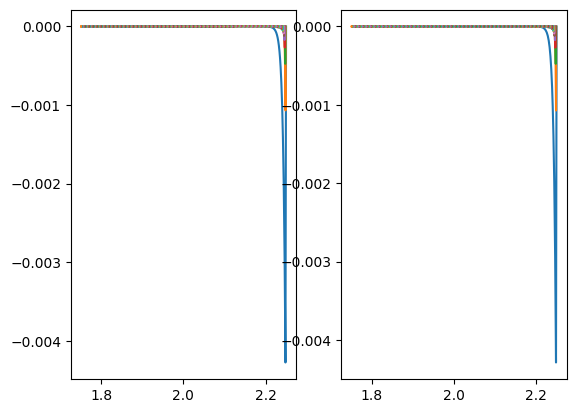

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

for solution in batch_ys:
    ax1.plot(solution[:,0], solution[:,1])

for solution in solutions_vmap.ys:
    ax2.plot(solution[:,0], solution[:,1])

In [11]:
for index, (sol_batch, sol_vmap) in enumerate(zip(batch_ys, solutions_vmap.ys)):
    norm = jnp.linalg.norm(sol_batch[-1] - sol_vmap[-1])

    if norm > 10e-5:
        print(index, sol_batch[-1], sol_vmap[-1])